In [38]:
import inspect
from functools import reduce

import numpy, scipy
from pyscf import gto, scf, fci, lo

def get_hdiag(x=1.0, basis='sto-3g', mo=None):
    mol = gto.Mole()
    mol.atom = [
        ['H', (0, 0, 0)],
        ['H', (0, 0, x)],
    ]
    mol.basis = basis
    mol.verbose = 0
    mol.build()

    ovlp_ao = mol.intor('int1e_ovlp')

    fci_obj = None
    ene_hf  = None

    if mo == "rhf":
        mf = scf.RHF(mol)
        mf.kernel()
        ene_hf = mf.energy_elec()[0]
        
        fci_obj = fci.FCI(mf)

    elif mo == "uhf":
        h1_1s_idx = mol.search_ao_label('1s')[0]
        h2_1s_idx = mol.search_ao_label('1s')[1]
        dm0 = numpy.zeros((2, mol.nao_nr(), mol.nao_nr()))
        dm0[0,h1_1s_idx,h1_1s_idx] = 1.0
        dm0[1,h2_1s_idx,h2_1s_idx] = 1.0

        mf = scf.UHF(mol)
        mf.kernel(dm0)
        ene_hf = mf.energy_elec()[0]
        fci_obj = fci.FCI(mf)
    
    elif mo == "iao":
        mf = scf.RHF(mol)
        mf.kernel()

        iao = lo.orth.lowdin(ovlp_ao)
        nlo = iao.shape[1]
        assert numpy.linalg.norm(reduce(numpy.dot, (iao.T, ovlp_ao, iao)) - numpy.eye(nlo)) < 1e-10

        fci_obj = fci.FCI(mol, iao)

    xx = inspect.signature(fci_obj.kernel)
    h1e = xx.parameters["h1e"].default
    eri = xx.parameters["eri"].default
    norb = xx.parameters["norb"].default
    nelec = xx.parameters["nelec"].default

    hdiag = fci_obj.make_hdiag(h1e, eri, norb, nelec)
    if ene_hf is None:
        ene_hf = numpy.min(hdiag)
    ene_fci, vec_fci = fci_obj.kernel(h1e, eri, norb, nelec)
    return ene_fci - mol.energy_nuc(), ene_hf, hdiag


In [39]:
from matplotlib import pyplot
import matplotlib as mpl
from matplotlib import cm

params = {
        "font.size":       18,
        "axes.titlesize":  20,
        "axes.labelsize":  20,
        "legend.fontsize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "figure.subplot.wspace":0.0,
        "figure.subplot.hspace":0.0,
        "axes.spines.right": True,
        "axes.spines.top":   True,
        "xtick.direction":'in',
        "ytick.direction":'in',
        "text.usetex": True,
        "font.family": "serif",
        'text.latex.preamble': r"\usepackage{amsmath}"
}
mpl.rcParams.update(params)

colors = ["2ab7ca", "fe4a49","fed766","00cc66","8c5383"]
colors = ["#"+color for color in colors]

fci_ene_dict = {
    "linestyle": "-",
    "marker": ">",
    "markersize": 10,
    "markevery": 1,
    "color": colors[-1],
}

rhf_hdiag_dict = {
    "color": colors[0],
    "linestyle": "-",
    "linewidth": 2,
    "alpha": 0.4
}

rhf_ene_dict = {
    "linestyle": "-",
    "marker": "o",
    "markersize": 10,
    "markevery": 1,
    "color": colors[0],
    "label": "RHF"
}

uhf_hdiag_dict = {
    "color": colors[1],
    "linestyle": "-",
    "linewidth": 2,
    "alpha": 0.4
}

uhf_ene_dict = {
    "linestyle": "-",
    "marker": "o",
    "markersize": 10,
    "markevery": 1,
    "color": colors[1],
    "label": "UHF"
}

iao_hdiag_dict = {
    "color": colors[2],
    "linestyle": "-",
    "linewidth": 2,
    "alpha": 0.4
}

iao_ene_dict = {
    "linestyle": "-",
    "marker": "o",
    "markersize": 10,
    "markevery": 1,
    "color": colors[2],
    "label": "IAO"
}


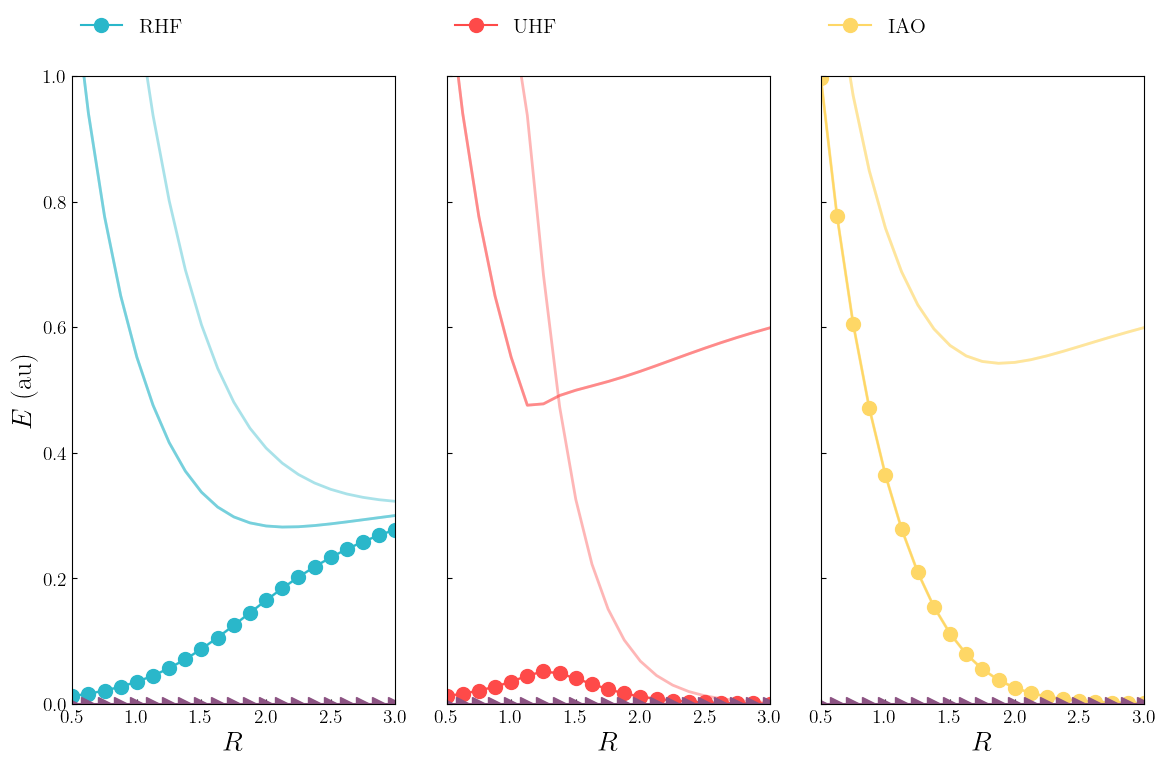

In [40]:
nn = 21
xx     = numpy.linspace(0.5, 3.0, nn)

ene_fci = []
ene_rhf = []
ene_uhf = []
ene_iao = []

hdiag_rhf = []
hdiag_uhf = []
hdiag_iao = []

basis = "sto-3g"
for x in xx:
    res = get_hdiag(x=x, basis=basis, mo="rhf")
    ene_fci.append(res[0])
    ene_rhf.append(res[1])
    hdiag_rhf.append(res[2])

    res = get_hdiag(x=x, basis=basis, mo="uhf")
    assert abs(res[0] - ene_fci[-1]) < 1e-10
    ene_uhf.append(res[1])
    hdiag_uhf.append(res[2])

    res = get_hdiag(x=x, basis=basis, mo="iao")
    assert abs(res[0] - ene_fci[-1]) < 1e-10
    ene_iao.append(res[1])
    hdiag_iao.append(res[2])

ene_fci = numpy.array(ene_fci)
ene_rhf = numpy.array(ene_rhf)
ene_uhf = numpy.array(ene_uhf)
ene_iao = numpy.array(ene_iao)

hdiag_rhf = numpy.array(hdiag_rhf)
hdiag_uhf = numpy.array(hdiag_uhf)
hdiag_iao = numpy.array(hdiag_iao)

fig, axs = pyplot.subplots(1, 3, figsize=(12, 8), sharey=True)
for ax, ene, hdiag, hdiag_dict, ene_dict in zip(axs, [ene_rhf, ene_uhf, ene_iao], [hdiag_rhf, hdiag_uhf, hdiag_iao], [rhf_hdiag_dict, uhf_hdiag_dict, iao_hdiag_dict], [rhf_ene_dict, uhf_ene_dict, iao_ene_dict]):
    ax.plot(xx, [hdiag[i] - ene_fci[i] for i in range(nn)], **hdiag_dict)
    ax.plot(xx, ene - ene_fci, **ene_dict)
    ax.plot(xx, ene_fci - ene_fci, **fci_ene_dict)

    ax.set_xlabel(r"$R$")
    ax.set_xlim(xx[0], xx[-1])
    ax.set_ylim(0.0, 1.0)
    ax.legend(
        loc=(0.0, 1.05), fancybox=False, framealpha=1.0,
        edgecolor='silver', frameon=False, fontsize=15, ncol=3
        )

axs[0].set_ylabel(r"$E$ (au)")
fig.tight_layout()

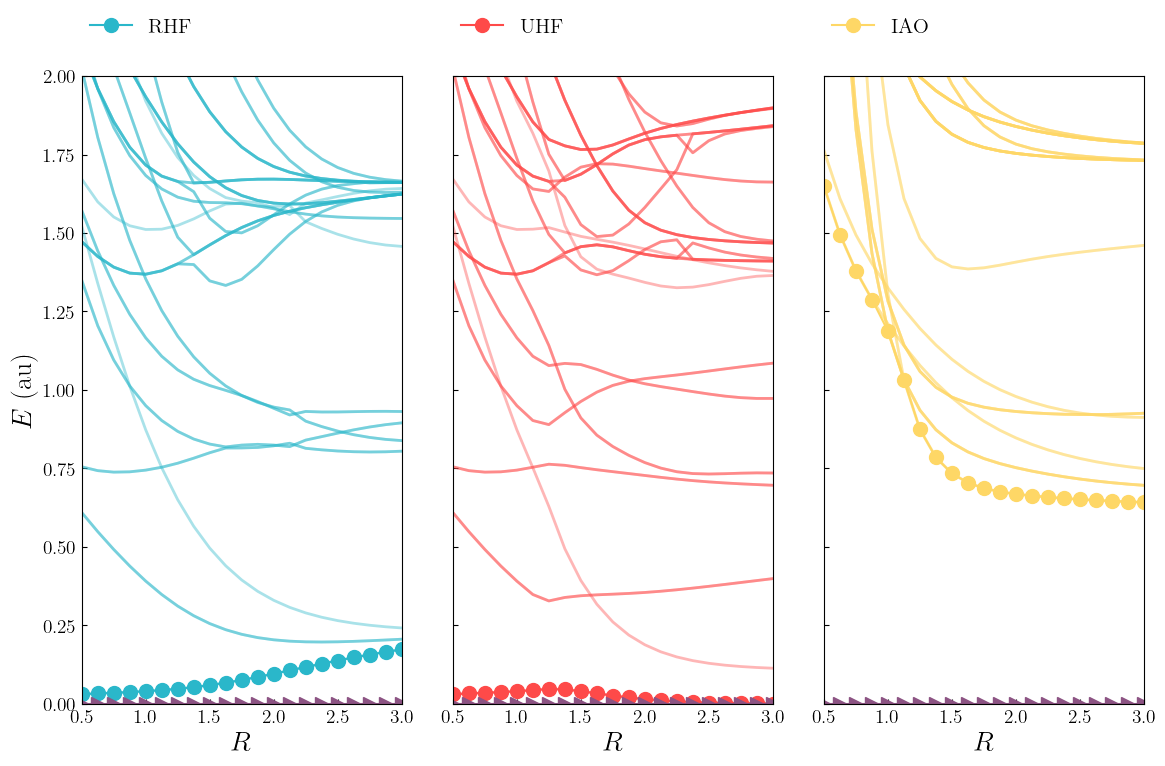

In [42]:
nn = 21
xx     = numpy.linspace(0.5, 3.0, nn)

ene_fci = []
ene_rhf = []
ene_uhf = []
ene_iao = []

hdiag_rhf = []
hdiag_uhf = []
hdiag_iao = []

basis = "cc-pvdz"
for x in xx:
    res = get_hdiag(x=x, basis=basis, mo="rhf")
    ene_fci.append(res[0])
    ene_rhf.append(res[1])
    hdiag_rhf.append(res[2])

    res = get_hdiag(x=x, basis=basis, mo="uhf")
    assert abs(res[0] - ene_fci[-1]) < 1e-10
    ene_uhf.append(res[1])
    hdiag_uhf.append(res[2])

    res = get_hdiag(x=x, basis=basis, mo="iao")
    assert abs(res[0] - ene_fci[-1]) < 1e-10
    ene_iao.append(res[1])
    hdiag_iao.append(res[2])

ene_fci = numpy.array(ene_fci)
ene_rhf = numpy.array(ene_rhf)
ene_uhf = numpy.array(ene_uhf)
ene_iao = numpy.array(ene_iao)

hdiag_rhf = numpy.array(hdiag_rhf)
hdiag_uhf = numpy.array(hdiag_uhf)
hdiag_iao = numpy.array(hdiag_iao)

fig, axs = pyplot.subplots(1, 3, figsize=(12, 8), sharey=True)
for ax, ene, hdiag, hdiag_dict, ene_dict in zip(axs, [ene_rhf, ene_uhf, ene_iao], [hdiag_rhf, hdiag_uhf, hdiag_iao], [rhf_hdiag_dict, uhf_hdiag_dict, iao_hdiag_dict], [rhf_ene_dict, uhf_ene_dict, iao_ene_dict]):
    ax.plot(xx, [hdiag[i] - ene_fci[i] for i in range(nn)], **hdiag_dict)
    ax.plot(xx, ene - ene_fci, **ene_dict)
    ax.plot(xx, ene_fci - ene_fci, **fci_ene_dict)

    ax.set_xlabel(r"$R$")
    ax.set_xlim(xx[0], xx[-1])
    ax.set_ylim(0.0, 2.0)
    ax.legend(
        loc=(0.0, 1.05), fancybox=False, framealpha=1.0,
        edgecolor='silver', frameon=False, fontsize=15, ncol=3
        )

axs[0].set_ylabel(r"$E$ (au)")
fig.tight_layout()